<a href="https://www.kaggle.com/code/juzykaggle/gradientboostingclassifier-0-8017?scriptVersionId=139404195" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


# Import necessary libraries

In [2]:
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
%matplotlib inline

# EDA

In [3]:
dataset_train = pd.read_csv('../input/spaceship-titanic/train.csv')
dataset_test = pd.read_csv('../input/spaceship-titanic/test.csv')

In [4]:
dataset_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


<Axes: >

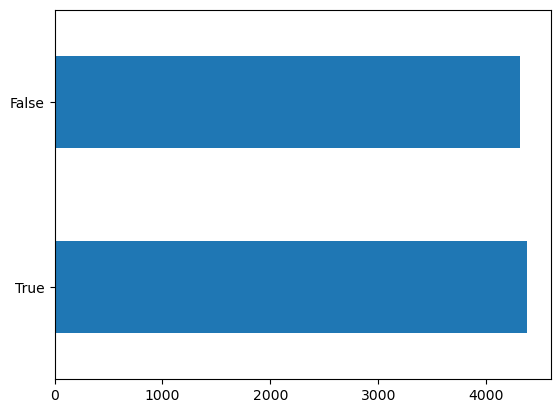

In [5]:
#Checking balance of target feature
plot_df = dataset_train.Transported.value_counts()
plot_df.plot(kind="barh")

In [6]:
dataset_train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [7]:
dataset_train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [8]:
# function for splitting 'Cabin', get dummies & processing
def processing(dataset):
    # drop name
    dataset = dataset.drop(['PassengerId', 'Name'], axis=1)
    
    # split Cabin
    dataset[["Deck", "Cabin_num", "Side"]] = dataset["Cabin"].str.split("/", expand=True)
    dataset = dataset.drop('Cabin', axis=1)

    # get dummies
    dataset = pd.get_dummies(dataset, columns = ['Destination', 'Deck', 'Side', 'HomePlanet'], drop_first=True )
    
    # filling missing values

    for i in list(dataset):
        dataset[i] = dataset[i].fillna(dataset[i].median())
        
    
    # to int
    dataset['CryoSleep'] = dataset['CryoSleep'].astype(int)
    dataset['VIP'] = dataset['VIP'].astype(int)
    
    return dataset
 

In [9]:
train = processing(dataset_train)
test = processing(dataset_test)

# Training model

In [10]:
X = train.drop('Transported', axis=1)
y = train.Transported

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [12]:
clf = GradientBoostingClassifier()

In [13]:
params = {'learning_rate': np.arange(0.05, 0.2, 0.03), 'n_estimators': range(100, 500, 100), 'max_depth': [2, 3, 5]}

In [14]:
grid_clf = RandomizedSearchCV(clf, param_distributions=params, cv=5).fit(X_train, y_train)

In [15]:
grid_clf.best_params_

{'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05}

In [16]:
best_grid_clf = grid_clf.best_estimator_
y_pred = best_grid_clf.predict(X_test)

In [17]:
# scores function
def scores(y_test, y_pred):
    print('precision = ', precision_score(y_test, y_pred))
    print('recall = ', recall_score(y_test, y_pred))
    print('accuracy = ', accuracy_score(y_test, y_pred))
    print('f1 = ', f1_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

In [18]:
scores(y_test, y_pred)

precision =  0.7778489116517285
recall =  0.8408304498269896
accuracy =  0.7988846287905194
f1 =  0.808114399733954
[[1077  347]
 [ 230 1215]]


In [19]:
y_pred_sub = best_grid_clf.predict(test)

In [20]:
sub = pd.read_csv('../input/spaceship-titanic/sample_submission.csv')

sub = sub.drop(['Transported'], axis=1)

y_pred_sub = pd.DataFrame(y_pred_sub)

submit = pd.concat([sub['PassengerId'], y_pred_sub], axis=1)

submit = submit.rename(columns = {0: 'Transported'})

submit['Transported'] = submit['Transported'].astype(bool)